In [1]:
%load_ext autoreload
%autoreload 2

# ERA5 distance average weighted remapping

This notebook shows how to do distance average weighted remapping with the
the [Climate Data Operators](https://code.mpimet.mpg.de/projects/cdo) tool
and using the `geoglue` library to facilitate remapping.

We will be remapping ERA5 data to the higher resolution WorldPop data,
focussing on Vietnam:

In [2]:
from pathlib import Path
from datetime import date

import xarray as xr
from geoglue.era5 import ERA5ZonalStatistics, resample
from geoglue.country import Country
from geoglue.memoryraster import MemoryRaster
from geoglue.util import geom_plot

VNM = Country("VNM")

T = date(2022, 1, 1)
# Helper plotting function
def plot(ds: xr.Dataset, i: int = 0):
    return ds.t2m.isel(valid_time=i).plot().axes.set_aspect('equal')

We read in the population file and check the shape. As ERA5 will crop the population to the geometry, this may change the shape of the population -- though in practice, we obtain already cropped population data from WorldPop

In [3]:
population = VNM.population_raster(2020)
population.griddes

CdoGriddes(gridtype='lonlat', gridsize=1565499, xsize=879, ysize=1781, xname='longitude', yname='latitude', ylongname='latitude', yunits='degrees_north', xfirst=102.14874960275003, xinc=0.0083333333, yfirst=8.557916831327146, yinc=0.0083333333, xlongname='longitude', xunits='degrees_east')

We now read in the downloaded ERA5 NetCDF file:

In [4]:
t2m_remapbil = ERA5ZonalStatistics("../79a080c8aaa9b3f1d4808e650202035c.nc", "VNM-2", population, resampling="remapbil")
t2m_remapbil.dataset

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 365, longitude: 879, latitude: 1781)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2022-01-01 ... 2022-12-31
  * longitude   (longitude) float64 7kB 102.1 102.2 102.2 ... 109.4 109.5 109.5
  * latitude    (latitude) float64 14kB 23.39 23.38 23.37 ... 8.575 8.566 8.558
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2GB ...
Attributes:
    CDI:                     Climate Data Interface version 2.5.0 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Mon Feb 10 16:31:23 2025: cdo -O -s -remapbil,/v...
    CDO:                     Climate Data Operators version 2.5.0 (https://mp...

We define a helper function to quickly display plot of the 't2m' (2m_temperature) variable at the first time index:

Now we will resample this using remapdis -- which is the CDO operator for distance-weighted average remapping. We will resample to the target grid, which in this case we want to be the population grid at a 1 km x 1 km resolution. CDO will upsample the data in this case. We also use remapbil (bilinear interpolation) for comparison

In [5]:
t2m_remapdis = ERA5ZonalStatistics("../79a080c8aaa9b3f1d4808e650202035c.nc", "VNM-2", population, resampling="remapdis")
t2m_remapdis.dataset

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 365, longitude: 879, latitude: 1781)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2022-01-01 ... 2022-12-31
  * longitude   (longitude) float64 7kB 102.1 102.2 102.2 ... 109.4 109.5 109.5
  * latitude    (latitude) float64 14kB 23.39 23.38 23.37 ... 8.575 8.566 8.558
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2GB ...
Attributes:
    CDI:                     Climate Data Interface version 2.5.0 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Thu Mar 06 22:13:07 2025: cdo -O -s -remapdis,/v...
    CDO:                     Climate Data Operators version 2.5.0 (https://mp...

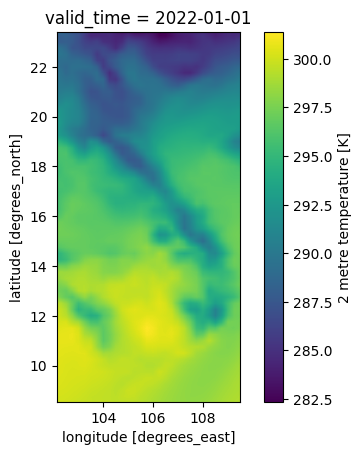

In [6]:
plot(t2m_remapbil.dataset)

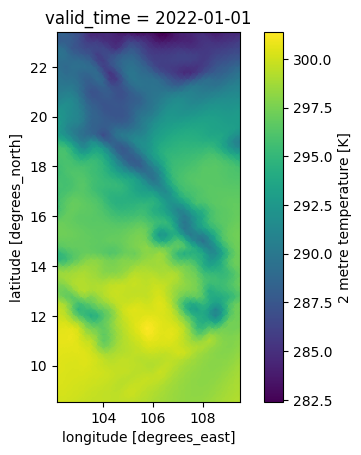

In [7]:
plot(t2m_remapdis.dataset)

In [8]:
remapbil = t2m_remapbil.zonal_daily("t2m", weighted=True, min_date=T, max_date=T)
remapdis = t2m_remapdis.zonal_daily("t2m", weighted=True, min_date=T, max_date=T)
diff = remapbil.copy()
diff["value"] = remapbil.value - remapdis.value
diff

Zonal daily for variable='t2m' using operation='mean(coverage_weight=area_spherical_km2)'


/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/src/geoglue/zonal_stats.py:183: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, df])
100%|█| 1/1 [00:00<00:00,  1.70it/s


Zonal daily for variable='t2m' using operation='mean(coverage_weight=area_spherical_km2)'


/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/geoglue/src/geoglue/zonal_stats.py:183: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, df])
100%|█| 1/1 [00:00<00:00,  1.70it/s


,GID_1,GID_2,NAME_1,NAME_2,value,date,ISO3,metric
0,VNM.1_1,VNM.1.1_1,An Giang,An Phú,-0.021274,2022-01-01,VNM,era5.2m_temperature.daily_mean
1,VNM.1_1,VNM.1.3_1,An Giang,Châu Đốc,-0.004816,2022-01-01,VNM,era5.2m_temperature.daily_mean
2,VNM.1_1,VNM.1.4_1,An Giang,Châu Phú,0.018741,2022-01-01,VNM,era5.2m_temperature.daily_mean
3,VNM.1_1,VNM.1.5_1,An Giang,Châu Thành,0.023418,2022-01-01,VNM,era5.2m_temperature.daily_mean
4,VNM.1_1,VNM.1.2_1,An Giang,Chợ Mới,-0.005170,2022-01-01,VNM,era5.2m_temperature.daily_mean
...,...,...,...,...,...,...,...,...
705,VNM.63_1,VNM.63.5_1,Yên Bái,Trấn Yên,0.057276,2022-01-01,VNM,era5.2m_temperature.daily_mean
706,VNM.63_1,VNM.63.6_1,Yên Bái,Văn Chấn,-0.151530,2022-01-01,VNM,era5.2m_temperature.daily_mean
707,VNM.63_1,VNM.63.7_1,Yên Bái,Văn Yên,0.095109,2022-01-01,VNM,era5.2m_temperature.daily_mean
708,VNM.63_1,VNM.63.8_1,Yên Bái,Yên Bái,0.135325,2022-01-01,VNM,era5.2m_temperature.daily_mean


<Axes: >

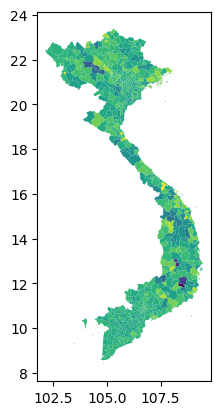

In [9]:
geom_plot(diff, VNM.admin(2), "value")